In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

C:\Users\Dimitri\workspaces\opensource\quantum-machine-learning


C:\Users\Dimitri\anaconda3\envs\quantum-machine-learning\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

from penny.classifier import BinaryClassifier, ClassifierContext
from penny.torch_classifier import *
from penny.models import *
from utils.embeddings import *
from utils.reporting import *
from utils.preprocess import *

In [4]:
random_seed = 123124
np.random.seed(random_seed)

In [5]:
# Load the iris dataset 
iris_features, iris_labels = load_iris(return_X_y=True)

In [6]:
scaler = StandardScaler()
iris_scaled_features = scaler.fit_transform(iris_features)
y = iris_labels
y_hot = OneHotEncoder(sparse_output=False).fit_transform(y.reshape(-1, 1))
X_scaled, y, y_hot = tensorize((iris_scaled_features, y, y_hot))
X_train, X_test, y_train, y_test, y_train_hot, y_test_hot = train_test_split(X_scaled, y, y_hot,
                                                                                 shuffle=True, test_size=0.2,
                                                                                 random_state=random_seed)

In [7]:
angle_tracker = HistoryTracker(X_train, y_train)
qubits = 4
num_classes = 3
classifier = IterationTorchClassifier(
        model=MultiClassQMLModel(qubits, num_classes=num_classes),
        num_classes=num_classes,
        weights_shape=(3, qubits, 3),
        iterations=100,
        report_fn=angle_tracker
    )

In [8]:
classifier.fit(X_train, y_train_hot)

Iter:    10 | Accuracy: 0.5500000 
Iter:    20 | Accuracy: 0.8250000 
Iter:    30 | Accuracy: 0.6666667 
Iter:    40 | Accuracy: 0.9250000 
Iter:    50 | Accuracy: 0.9083333 
Iter:    60 | Accuracy: 0.9083333 
Iter:    70 | Accuracy: 0.7666667 
Iter:    80 | Accuracy: 0.8083333 
Iter:    90 | Accuracy: 0.7833333 
Iter:   100 | Accuracy: 0.8333333 


In [9]:
predictions_test = classifier.predict(X_test)
cr = classification_report(y_test, predictions_test)
print(cr)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        12
         1.0       1.00      0.56      0.71         9
         2.0       0.75      1.00      0.86         9

    accuracy                           0.87        30
   macro avg       0.89      0.85      0.84        30
weighted avg       0.89      0.87      0.86        30



In [10]:
X_train_stereo = np.apply_along_axis(inverse_stereographic_projection, 1, X_train)
X_test_stereo = np.apply_along_axis(inverse_stereographic_projection, 1, X_test)
X_train_stereo, X_test_stereo = tensorize((X_train_stereo, X_test_stereo))

In [11]:
stereo_tracker = HistoryTracker(X_train_stereo, y_train)
qubits = 3
num_classes = 3

model = MultiClassQMLModel(qubits, num_classes=num_classes, embedding_fn=amplitude_embedding_fn)

classifier = IterationTorchClassifier(
        model=model,
        num_classes=num_classes,
        weights_shape=(3, qubits, 3),
        iterations=100,
        report_fn=stereo_tracker)

In [12]:
classifier.fit(X_train_stereo, y_train_hot)

Iter:    10 | Accuracy: 0.8000000 
Iter:    20 | Accuracy: 0.7000000 
Iter:    30 | Accuracy: 0.7416667 
Iter:    40 | Accuracy: 0.8083333 
Iter:    50 | Accuracy: 0.8250000 
Iter:    60 | Accuracy: 0.7666667 
Iter:    70 | Accuracy: 0.8416667 
Iter:    80 | Accuracy: 0.8750000 
Iter:    90 | Accuracy: 0.9083333 
Iter:   100 | Accuracy: 0.9000000 


In [13]:
predictions_test = classifier.predict(X_test_stereo)
cr = classification_report(y_test, predictions_test)
print(cr)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      0.78      0.88         9
         2.0       0.82      1.00      0.90         9

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.92        30
weighted avg       0.95      0.93      0.93        30



C:\Users\Dimitri\AppData\Local\Temp\ipykernel_37104\4073089542.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<Axes: title={'center': 'Performance comparison for Embeddings'}>

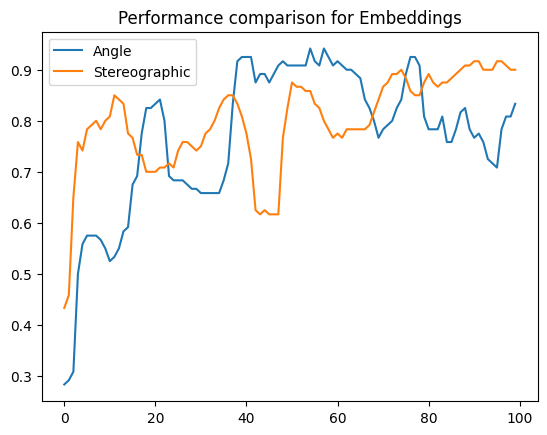

In [14]:
import pandas as pd

df = pd.DataFrame(list(zip(angle_tracker.history, stereo_tracker.history)), 
                  columns=['Angle', 'Stereographic'])
df.plot(title='Performance comparison for Embeddings')